In [1960]:
import csv
import matplotlib.pyplot as plt
from operator import itemgetter, attrgetter
import pandas as pd
import seaborn as sn
import math
import scipy.spatial as spatial
import scipy.stats as stats
import numpy as np
import mpl_scatter_density # adds projection='scatter_density'
from matplotlib.colors import LinearSegmentedColormap
import os

In [1961]:
#Constants
INTERESTING_PATHS = [
    '../sashas-scripts/manyAct_steps/',
    '../sasha-tacas-scripts/tacasHandcraftedModels/',
    '../sasha-tacas-scripts/tacasRealModels/',
    '../sasha-tacas-scripts/tacasRandomConnected/',
]
PATH_TO_CSV_FOLDER = INTERESTING_PATHS[-3]
print("Chosen Path: "+PATH_TO_CSV_FOLDER)

Chosen Path: ../sasha-tacas-scripts/tacasHandcraftedModels/


## Load Data

In [1984]:
property_meta_keys = ["Model"]

property_keys = [
    "NumStates",
    "NumActions",
    "NumTargets",
    "NumSinks",
    "NumUnknown",
    "NumMaxActions",
    "NumMaxTransitions",
    "SmallestTransProb",
    "NumProbActions",
    "NumMECs",
    "BiggestMEC",
    "SmallestMEC",
    "AvgMEC",
    "MedianMEC",
    "NumSCCs",
    "BiggestSCC",
    "AvgSCC",
    "NearestTarget",
    "FurthestTarget"
]

analysis_keys = property_meta_keys + property_keys

unknown_threshold = 5
def is_float(entry):
    try:
        float_entry = float(entry)
        return True
    except ValueError:
        return False
    
def is_property_defined(prop, keys, row):
    return (prop in keys and
            is_float(row[prop]))

def should_remove_model(row_to_include, analysis_keys, filter_dict):
    GENERAL_FILTERS = True
    if (GENERAL_FILTERS and not is_property_defined("NumStates", analysis_keys, row_to_include)):
        filter_dict["Timeout"] +=1
        return True
    elif (GENERAL_FILTERS and is_property_defined("NumUnknown", analysis_keys, row) and int(row_to_include["NumUnknown"]) <= unknown_threshold):
        filter_dict["Unknown<=%d" % unknown_threshold] +=1
        print("Model %s has less than %d unknown states --> too easy " % (row["Model"], unknown_threshold))
        return True
    
    #Special Filtering Criteria for different test-suites
    SPECIAL_FILTERS = True
    if (SPECIAL_FILTERS):
        filter_conditions = [
            "hm_25" in row_to_include["Model"],
            #int(row_to_include["NumStates"]) <= 7000,
            #int(row_to_include["NumStates"]) < 1000,
            #not "MinAct_10" in row_to_include["Model"],
            #"MinTransProb" in row_to_include["Model"],
            #"Type-tree" in row_to_include["Model"]
        ]
        
        if (True in filter_conditions):
            return True
        
        
    return False

def normalization(row, analysis_keys):
    if (is_property_defined("NumStates", analysis_keys, row)):
        for value_to_normalize in [
            "NumTargets",
            "NumSinks",
            "NumUnknown",
        ]:
            if (value_to_normalize in analysis_keys):
                row[value_to_normalize] = float(row[value_to_normalize]) / float(row["NumStates"]) 

filter_dict = dict()
filter_dict["Unknown<=%d" % unknown_threshold] = 0 #Not an interesting model
filter_dict["Timeout"] = 0
filter_dict["SpecialFilters"] = 0
table_properties = []
total_rows = 0
with open(PATH_TO_CSV_FOLDER+'analysis.csv', newline='\n') as propertiesFile:
        reader = csv.DictReader(propertiesFile)
        for row in reader:
            total_rows += 1
            row_to_include = {k:row[k] for k in analysis_keys if k in row}
            
            
            
            for key in analysis_keys:
                if (row_to_include[key] == " ?"):
                    row_to_include[key] = 0

            #Filtering
            if (should_remove_model(row_to_include, analysis_keys, filter_dict)):
                continue

            #Normalizations
            normalization(row_to_include, analysis_keys)

            table_properties.append(row_to_include)

print("With filtering there are %d/%d models left to check from" % (len(table_properties), total_rows))
print("The rest was filtered because of following reasons: ")
print(filter_dict)

With filtering there are 10/11 models left to check from
The rest was filtered because of following reasons: 
{'Unknown<=5': 0, 'Timeout': 0, 'SpecialFilters': 0}


In [1985]:
#print(*list(map(lambda x : (x["Model"]), table_properties)), sep= "\n")

In [1986]:
metaKeys = ["Model", "#States"]

tacas_keys = [
    "BVI",
    "D_BVI",
    "D_SVI",
    "G_BVI",
    "G_OVI",
    "G_SVI",
    "OPT_OVI",
    "OVI",
    "SVI",
    "TOP_BVI",
    "TOP_OVI",
    "TOP_SVI",
    #"TOP_VI",
    "T_BVI",
    "T_OVI",
    #"T_SVI",
    "VI",
    "WP"
]

reduced_config_keys = [
    #"BVI_D",
    "BVI_100",
    ##"GBVI_1",
    ##"GBVI_100",
    #"GSVI_100",
    #"OVI_1",
    "OVI_100",
    ##"OVI_1_opt",
    "SVI_100",
    #"TBVI_1",
    "TBVI_100",
    ##"TGBVI_100",
    #"TGSVI_100",
    #"TOVI_100",
    #"TOVI_1_opt",
    #"TOVI_100_opt"
    #"TSVI_100",
    #"VI"
]

config_keys = tacas_keys

relevantKeys = metaKeys + config_keys
relevantKeys

['Model',
 '#States',
 'BVI',
 'D_BVI',
 'D_SVI',
 'G_BVI',
 'G_OVI',
 'G_SVI',
 'OPT_OVI',
 'OVI',
 'SVI',
 'TOP_BVI',
 'TOP_OVI',
 'TOP_SVI',
 'T_BVI',
 'T_OVI',
 'VI',
 'WP']

#### Check for Errors

In [1987]:
SEARCH_ERRORS = True
if (SEARCH_ERRORS):
    for conf in config_keys:
        conf_path = PATH_TO_CSV_FOLDER+conf+"/"
        for model_file_name in os.listdir(conf_path):
            with open(conf_path+model_file_name, newline='\n') as conf_model_run:
                for line in conf_model_run:
                    if ("Exception" in line or "Error" in line):
                        print("IN CONF %s AND FILE \n%s: " % (conf, model_file_name))
                        print(line)

IN CONF TOP_SVI AND FILE 
ManyMECs_1e2.log: 
Error: State 198 was suspected to get value 0.2 by playing an action from set [0] but 0 would only yield value 0.0, which is not optimal. Thus, the TOP heuristic failed. Try another solution method...

IN CONF TOP_SVI AND FILE 
ManyMECs_1e1.log: 
Error: State 18 was suspected to get value 0.2 by playing an action from set [0] but 0 would only yield value 0.0, which is not optimal. Thus, the TOP heuristic failed. Try another solution method...

IN CONF TOP_SVI AND FILE 
ManyMECs_1e3.log: 
Error: State 1998 was suspected to get value 0.2 by playing an action from set [0] but 0 would only yield value 0.0, which is not optimal. Thus, the TOP heuristic failed. Try another solution method...



#### Load Config Data

In [1988]:
#Filtering Options

def should_remove_model_conf(at_least_one_has_solved, at_least_one_has_not_solved):
    return False
    #return at_least_one_has_not_solved
    #return not at_least_one_has_solved

In [1989]:
def modelIncludedInProperties(model_name, table_properties):
    for row in table_properties:
        if row["Model"] == model_name:
            return True
    return False

In [1990]:
table_times = []
excluded_times = []
print("PATH: ",PATH_TO_CSV_FOLDER+'times.csv')

conf_filter_dict = dict()
conf_filter_dict["NooneHasSolved"] = 0

with open(PATH_TO_CSV_FOLDER+'times.csv', newline='\n') as timesFile:
    reader = csv.DictReader(timesFile)
    for row in reader:
        parsed_row = {k:row[k] for k in relevantKeys if k in row}

        # Filtering
        if not modelIncludedInProperties(parsed_row["Model"], table_properties):
            continue
        if parsed_row["#States"] == '' or parsed_row["#States"] == None:
            parsed_row["#States"] = 100020
            pass
        at_least_one_has_solved = False
        at_least_one_has_not_solved = False
        for config_key in config_keys:
            if (is_float(parsed_row[config_key])):
                at_least_one_has_solved = True
                #print(parsed_row)
            else:
                print("%s couldn't solve %s" % (config_key, parsed_row["Model"]))
                at_least_one_has_not_solved = True


        if (should_remove_model_conf(at_least_one_has_solved, at_least_one_has_not_solved)):
            conf_filter_dict["NooneHasSolved"]+=1
            excluded_times.append(parsed_row)
        else:
            table_times.append(parsed_row)
print("After filtering, %d models are left in total" % len(table_times))
print("The not included confs are due to the following reasons: ")
print(conf_filter_dict)

PATH:  ../sasha-tacas-scripts/tacasHandcraftedModels/times.csv
TOP_BVI couldn't solve BigMec_1e4
TOP_OVI couldn't solve BigMec_1e4
TOP_SVI couldn't solve BigMec_1e4
TOP_SVI couldn't solve ManyMECs_1e1
TOP_SVI couldn't solve ManyMECs_1e2
T_BVI couldn't solve ManyMECs_1e2
D_SVI couldn't solve ManyMECs_1e3
TOP_SVI couldn't solve ManyMECs_1e3
T_BVI couldn't solve ManyMECs_1e3
After filtering, 10 models are left in total
The not included confs are due to the following reasons: 
{'NooneHasSolved': 0}


In [1991]:
table_iters = []
excluded_iters = []
print("PATH: ",PATH_TO_CSV_FOLDER+'iters.csv')

conf_filter_dict = dict()
conf_filter_dict["NooneHasSolved"] = 0

with open(PATH_TO_CSV_FOLDER+'iters.csv', newline='\n') as iters:
    reader = csv.DictReader(iters)
    for row in reader:
        parsed_row = {k:row[k] for k in relevantKeys if k in row}

        # Filtering
        if not modelIncludedInProperties(parsed_row["Model"], table_properties):
            continue
        if not is_float(parsed_row["#States"]):
            parsed_row["#States"] = 100020
            pass
        at_least_one_has_solved = False
        at_least_one_has_not_solved = False
        for config_key in config_keys:
            if (parsed_row[config_key] != "" and parsed_row[config_key] != " "):
                at_least_one_has_solved = True
            else:
                at_least_one_has_not_solved = True


        if (should_remove_model_conf(at_least_one_has_solved, at_least_one_has_not_solved)):
            conf_filter_dict["NooneHasSolved"]+=1
            excluded_iters.append(parsed_row)
        else:
            table_iters.append(parsed_row)
print("After filtering, %d models are left in total" % len(table_iters))
print("The not included confs are due to the following reasons: ")
print(conf_filter_dict)

PATH:  ../sasha-tacas-scripts/tacasHandcraftedModels/iters.csv
After filtering, 10 models are left in total
The not included confs are due to the following reasons: 
{'NooneHasSolved': 0}


In [1992]:
#Test Read Filed
for row in table_times:
    #print(row)
    pass

for row in table_properties:
    pass

### Unify Data

In [1993]:
table_times = sorted(table_times, key=lambda row: int(row['#States']))
table_properties = sorted(table_properties, key=lambda row: int(row['NumStates']))

In [1994]:
USE_TIMES = True
USE_ITERS = False

threshold_time = 15 * 60
threshold_iter = 1000000000
PENTALY_FOR_NOT_FINISHING = min(15 * 60, threshold_time) #900s is 15 min computation time
CLIP_DATA = True

print("USE_TIMES: %r, USE_ITER: %r, SHOULD CLIP? %r" % (USE_TIMES, USE_ITERS, CLIP_DATA))

iter_prefix = "" if (not USE_TIMES) else "Iter_"

data = dict()
model_names = []
for key in property_keys:
        data[key] = []
for key in config_keys:
        data[key] = []
        if (USE_TIMES and USE_ITERS):
            data[iter_prefix+key] = []


def getIndexOfModelInTable(table, modelName, use):
    if (use):
        for j in range(len(table)):
            if (table[j]["Model"] == modelName):
                return j
    return -1

def shouldKeepModel(index, use):
    return ((not use) or (use and index >=0))
          
    
#Gather the whole data
#Highly inefficient I suppose
for i in range(len(table_properties)):
    properties_row = table_properties[i]
    
    iter_index = getIndexOfModelInTable(table_iters, properties_row["Model"], USE_ITERS)
    time_index = getIndexOfModelInTable(table_times, properties_row["Model"], USE_TIMES)
    
    #Should keep row?
    if (not shouldKeepModel(time_index, USE_TIMES)):
        continue
    elif (not shouldKeepModel(iter_index, USE_ITERS)):
        continue
    
    model_names.append(properties_row["Model"])
    #Parse Data
    for key in property_keys:
                if (not is_float(properties_row[key])):
                      data[key].append(0)
                else: 
                        data[key].append(float(properties_row[key]))

    for key in config_keys:
            #Times
            if (USE_TIMES):
                times_row = table_times[time_index]
                if (not is_float(times_row[key])):
                        data[key].append(PENTALY_FOR_NOT_FINISHING)
                else:
                        entry = float(times_row[key])
                        entry = min(entry, threshold_time) if CLIP_DATA else entry
                        data[key].append(entry)
            
            #Iters
            if (USE_ITERS):
                iters_row = table_iters[iter_index]
                if (not is_float(iters_row[key])):
                        data[iter_prefix+key].append(1000) # How to set penatly for not finishing fo iters?
                else:
                        entry = int(iters_row[key])
                        entry = min(entry, threshold_iter) if CLIP_DATA else entry
                        data[iter_prefix+key].append(entry)

USE_TIMES: True, USE_ITER: False, SHOULD CLIP? True


### Attach labels if you want to

In [1995]:
USE_LABELS = False
if (USE_LABELS):
    model_name_labels = [
        "MinAct_2", #Default Label
        "MinAct_5",
        "MinAct_10",
    ]
    labeling = []

    counter = 0
    for model in model_names:
        for label in model_name_labels:
            if (label in model):
                labeling.append(label)
                break
        counter+=1
        if (counter > len(labeling)):
            labeling.append(model_name_labels[0])

    color_options = [
        "blue",
        "red",
        "green",
        "cyan"
    ]
    
    pandas_labels = pd.Series(labeling)

    coloring = dict()
    for i in range(len(model_name_labels)):
        coloring[model_name_labels[i]] = color_options[i]

    print(coloring)

In [1996]:
def findModelWithNameInTable(table, modelName):
    for row in table:
        if row["Model"] == modelName:
            return row

### Look at Models left

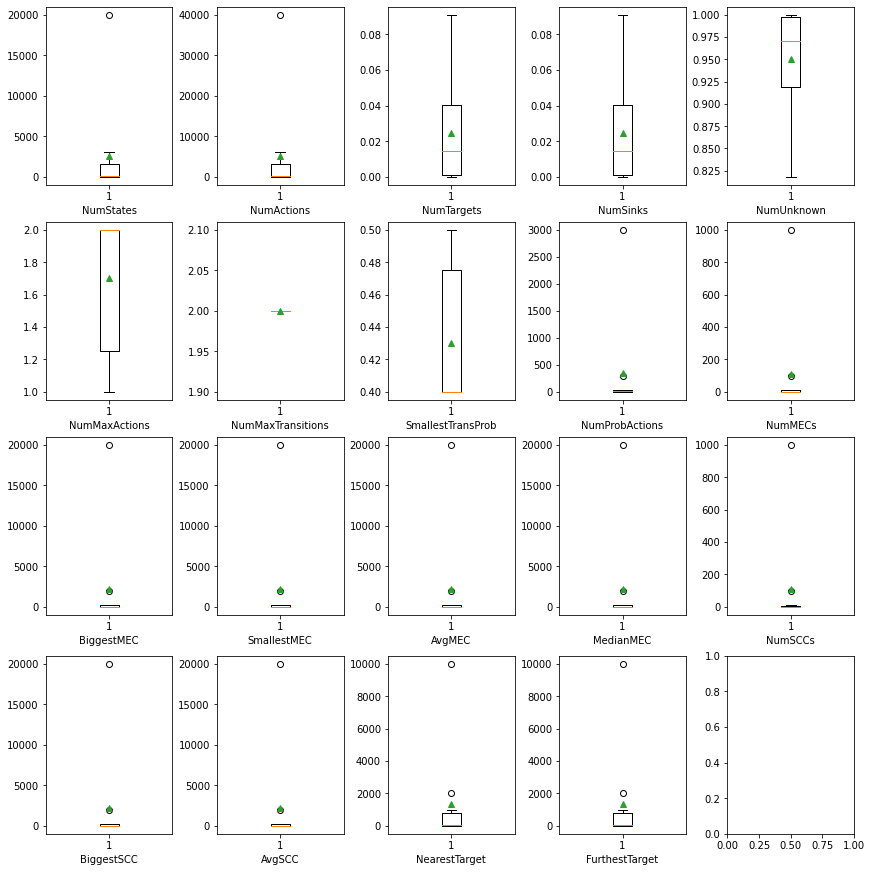

In [1997]:
#Make Boxplots

entries_per_column = 5
entries_per_row = int(math.ceil(len(property_keys)/5))
fix, axs = plt.subplots(entries_per_row, entries_per_column, figsize=(12,12), constrained_layout=True)
row = 0
column = 0
for property_key in property_keys:
        if (column == entries_per_column):
            row += 1
            column = 0
        axs[row, column].boxplot(data[property_key], showmeans=True)
        axs[row, column].set_xlabel(property_key)
        column+=1

In [1998]:
#Print out specific stuff you are interested in
data_as_np = dict(data)
for key in data_as_np.keys():
    data_as_np[key] = np.asarray(data_as_np[key])
    
#for key in property_keys:    
for key in ["NumStates", "BiggestMEC", "NumMECs", "NumMaxActions", "NumProbActions", "NumUnknown"]:
    print("Key: ", key)
    print("\t Min: ",data_as_np[key].min())
    print("\t Max: ",data_as_np[key].max())
    print("\t Mean: ",data_as_np[key].mean())

Key:  NumStates
	 Min:  11.0
	 Max:  20003.0
	 Mean:  2564.1
Key:  BiggestMEC
	 Min:  0.0
	 Max:  20001.0
	 Mean:  2223.3
Key:  NumMECs
	 Min:  0.0
	 Max:  1000.0
	 Mean:  111.4
Key:  NumMaxActions
	 Min:  1.0
	 Max:  2.0
	 Mean:  1.7
Key:  NumProbActions
	 Min:  2.0
	 Max:  3000.0
	 Mean:  340.5
Key:  NumUnknown
	 Min:  0.8181818181818182
	 Max:  0.9999000149977504
	 Mean:  0.9506467270327453


## Look at some graph to gain understanding of dataset

In [1999]:
x_axis = range(len(table_times))
y_axises = dict()

#Init y_axises
for key in config_keys:
    y_axises[key] = data[key]

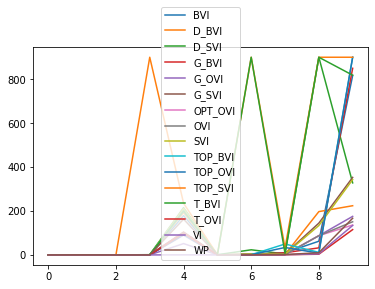

In [2000]:
for config in y_axises.keys():
    plt.plot(x_axis, y_axises[config], label=config)
plt.legend()
plt.show()

Conf VI: 	140.619000
Conf T_OVI: 	218.114000
Conf OPT_OVI: 	317.218000
Conf G_OVI: 	319.194000
Conf OVI: 	339.377000
Conf WP: 	342.353000
Conf G_SVI: 	610.453000
Conf D_BVI: 	619.038000
Conf SVI: 	695.556000
Conf G_BVI: 	997.667000
Conf TOP_OVI: 	1035.026000
Conf BVI: 	1071.391000
Conf TOP_BVI: 	1164.862000
Conf D_SVI: 	1473.324000
Conf T_BVI: 	2826.281000
Conf TOP_SVI: 	3867.689000


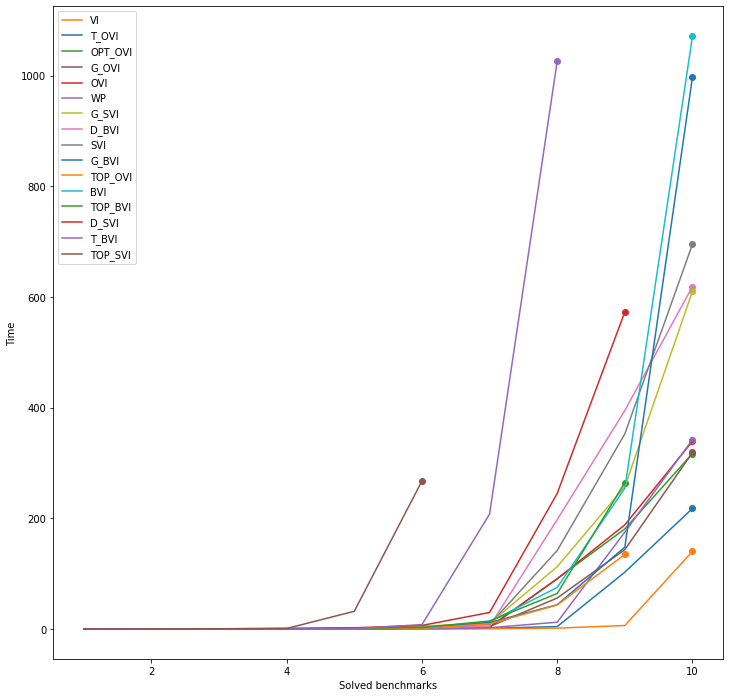

In [2001]:
# Since we want to sort legend by when an algo stops (So e.g. condon first, as it solves only 5), we need this method to find min. 
# for_ordering is a dict that maps each algo to a tuple: (Number of solved benchmarks, time to solve them all)
def my_min(for_ordering):
    min = (math.inf,math.inf) #certainly greater, as only 34 benchmarks
    min_algo = "None"
    for algo in for_ordering.keys():
        bench,time = for_ordering[algo]
        
        if bench < min[0] or (bench == min[0] and time > min[1]):
            min = (bench,time)
            min_algo = algo
    return min_algo

for algo in config_keys:
    subres = [float(i) for i in data[algo] if (i != PENTALY_FOR_NOT_FINISHING)]
    subres.sort()
    myDict[algo] = [i for i in subres]
    if (subres == []):
        print("For Algo %s not one model was solved" % (algo))
    for_ordering[algo] = (len(subres),subres[len(subres)-1])

# Get a list of algos in order for the legend
ordered_algos = []
while bool(for_ordering):
    min_algo = my_min(for_ordering)
    ordered_algos += [min_algo]
    for_ordering.pop(min_algo)


#print(myDict)

fig1, ax1 = plt.subplots(figsize=(12,12))
ax1.set_xlabel("Solved benchmarks")
ax1.set_ylabel("Time")

#fig2, ax2 = plt.subplots()
#ax2.set_xlabel("Time")
#ax2.set_ylabel("Solved benchmarks")


x = range(1,len(data["NumStates"])+1)

#x2 = range(0,1700)

legend_sorting = []
runtimes = dict()
for conf in config_keys:
    runtimes[conf] = np.array(data[conf]).sum()
    legend_sorting.append([conf, runtimes[conf]])
legend_sorting.sort(key = lambda x : x[1])
for conf in legend_sorting:
    print("Conf %s: \t%f" % (conf[0], conf[1]))

ordered_algos.reverse()
for algo in ordered_algos:
    y = [sum(myDict[algo][:i+1]) for i in range(0,len(myDict[algo])) if myDict[algo][i] != PENTALY_FOR_NOT_FINISHING]
    ax1.plot([i for i in x if i<=len(myDict[algo])],y, label=algo)
    ax1.scatter(x[len(myDict[algo])-1],y[len(myDict[algo])-1])
    handles, labels = ax1.get_legend_handles_labels()
    # sort both labels and handles by labels
    labels, handles = zip(*sorted(zip(labels, handles), key=lambda t: runtimes[t[0]]))
    #print(labels)
    #print(handles)
    ax1.legend(handles, labels)
    #plt.legend(loc="upper left")
    
    """
    if algo == "19":
    ax1.plot([i for i in x if i<=len(myDict[algo])],y, label=algo, c='tab:brown', zorder=1)
    ax1.scatter(x[len(myDict[algo])-1],y[len(myDict[algo])-1], s=30, marker='*', c='tab:brown', zorder=2)
    """

#fig2.savefig('Time2Bench')



(0.0, 900.0)

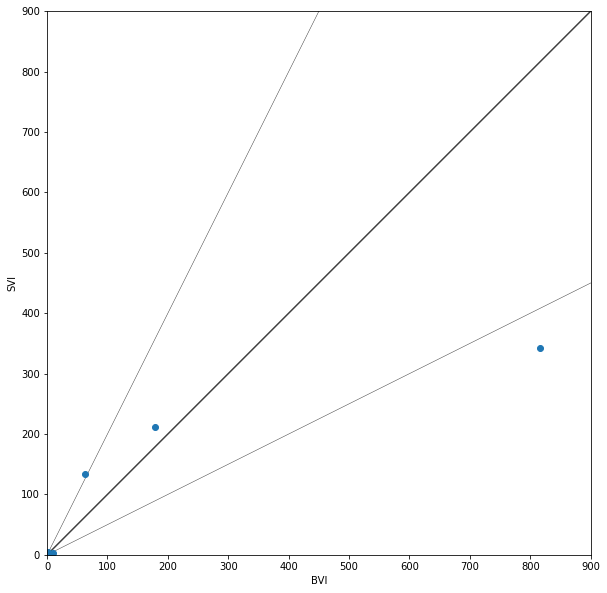

In [2002]:
#Use scale that doubles itself (as in OVI paper)
algo_on_x = "BVI"
algo_on_y = "SVI"

#Transform Data
data_for_x = data[algo_on_x]
data_for_y = data[algo_on_y]

axis_limits = [0,PENTALY_FOR_NOT_FINISHING]

fig, ax = plt.subplots(figsize=(10,10))
ax.scatter(data[algo_on_x], data[algo_on_y])
ax.plot(axis_limits, axis_limits, 'k-', alpha=0.75, zorder=0)
ax.plot(list(map(lambda x : x * 2, axis_limits)), axis_limits, 'k-', alpha=0.75, zorder=0, linewidth = 0.5)
ax.plot(list(map(lambda x : x / 2, axis_limits)), axis_limits, 'k-', alpha=0.75, zorder=0, linewidth = 0.5)
ax.set_aspect('equal')
ax.set_xlabel(algo_on_x)
ax.set_ylabel(algo_on_y)
ax.set_xlim(axis_limits)
ax.set_ylim(axis_limits)

### Interpret the graph

In [2003]:
print(len(model_names))
print(len(data["NumStates"]))

10
10


In [2007]:
#Get names of models above certain threshold

absolute_allowed_timedifference_in_seconds = 2
relative_allowed_timedifference = 0.1 # 0.1 -> 10% allowed difference
USE_RELATIVE_ERROR = True

confs_to_compare = config_keys
#confs_to_compare = ["OVI_1", "OVI_100"]

fastest_solver = dict()
for index in range(len(data["NumStates"])):
    model = model_names[index]
    print("MODEL: %s" % model)
    fastest_solver[model] = [10000000, []]
    for key in confs_to_compare:
        soln_time = data[key][index]
        print("Conf %s soln time %f" % (key, soln_time))
        if (soln_time != PENTALY_FOR_NOT_FINISHING):
            #print("This is better than NOT FINISHING")
            if (fastest_solver[model][0] > soln_time):
                # Check which of the currently saved models are in the allowed precision
                new_soln_time = fastest_solver[model][0]
                fastest_solvers_for_model = [key]
                for old_key in fastest_solver[model][1]:
                    old_soln_time = data[old_key][index]
                    # Do comparison
                    include_old_key = False
                    
                    USE_RELATIVE_ERROR = new_soln_time > 10
                    
                    if (USE_RELATIVE_ERROR):
                        include_old_key = (1.0 - relative_allowed_timedifference) * new_soln_time <= old_soln_time
                    else:
                        include_old_key = abs(new_soln_time - old_soln_time) <= absolute_allowed_timedifference_in_seconds
                    
                    if (include_old_key):
                        fastest_solvers_for_model.append(old_key)
                
                fastest_solver[model] = [soln_time, fastest_solvers_for_model]
                
            elif (fastest_solver[model][0] == soln_time):
                fastest_solver[model][1].append(key)

MODEL: hm_5
Conf BVI soln time 0.053000
Conf D_BVI soln time 0.101000
Conf D_SVI soln time 0.132000
Conf G_BVI soln time 0.074000
Conf G_OVI soln time 0.065000
Conf G_SVI soln time 0.097000
Conf OPT_OVI soln time 0.120000
Conf OVI soln time 0.106000
Conf SVI soln time 0.114000
Conf TOP_BVI soln time 0.164000
Conf TOP_OVI soln time 0.082000
Conf TOP_SVI soln time 0.087000
Conf T_BVI soln time 0.126000
Conf T_OVI soln time 0.149000
Conf VI soln time 0.047000
Conf WP soln time 0.098000
MODEL: hm_10
Conf BVI soln time 0.323000
Conf D_BVI soln time 0.248000
Conf D_SVI soln time 0.377000
Conf G_BVI soln time 0.172000
Conf G_OVI soln time 0.172000
Conf G_SVI soln time 0.347000
Conf OPT_OVI soln time 0.238000
Conf OVI soln time 0.246000
Conf SVI soln time 0.429000
Conf TOP_BVI soln time 0.330000
Conf TOP_OVI soln time 0.259000
Conf TOP_SVI soln time 0.503000
Conf T_BVI soln time 0.327000
Conf T_OVI soln time 0.220000
Conf VI soln time 0.177000
Conf WP soln time 0.396000
MODEL: BigMec_1e1
Conf 

In [2005]:
bestSolvers = dict()
for config_key in confs_to_compare:
    bestSolvers[config_key] = 0

for index in range(len(data["NumStates"])):
    model_name = model_names[index]
    for config_key in fastest_solver[model_name][1]:
        bestSolvers[config_key]+=1

for config_key in confs_to_compare:
    print("Config %s was the best solution method %d / %d times" % (config_key, bestSolvers[config_key], len(table_times)))

Config BVI was the best solution method 8 / 10 times
Config D_BVI was the best solution method 5 / 10 times
Config D_SVI was the best solution method 0 / 10 times
Config G_BVI was the best solution method 5 / 10 times
Config G_OVI was the best solution method 4 / 10 times
Config G_SVI was the best solution method 0 / 10 times
Config OPT_OVI was the best solution method 3 / 10 times
Config OVI was the best solution method 2 / 10 times
Config SVI was the best solution method 0 / 10 times
Config TOP_BVI was the best solution method 1 / 10 times
Config TOP_OVI was the best solution method 2 / 10 times
Config TOP_SVI was the best solution method 0 / 10 times
Config T_BVI was the best solution method 1 / 10 times
Config T_OVI was the best solution method 7 / 10 times
Config VI was the best solution method 4 / 10 times
Config WP was the best solution method 1 / 10 times


In [2006]:
#If you want to know which Models a Conf won, use this:
check_conf = "TBBVI_100"
explicit = True

for index in range(len(data["NumStates"])):
    model = model_names[index]
    if check_conf in fastest_solver[model][1]:
        print(model)
        if explicit:
            props = findModelWithNameInTable(table_properties, model)
            #print(props["NumSCCs"])
            for prop in props:
                print(prop," : ", props[prop])

# Do classic Data Mining stuff

## Heatmaps

In [1800]:
excluded_features = [
    #"NumTargets",
    #"SmallestTransProb"
]

correlation_dict = dict(data)

for feature in excluded_features:
    del correlation_dict[feature]

size = len(analysis_keys) - len(excluded_features) + len(config_keys)
print(size)

36


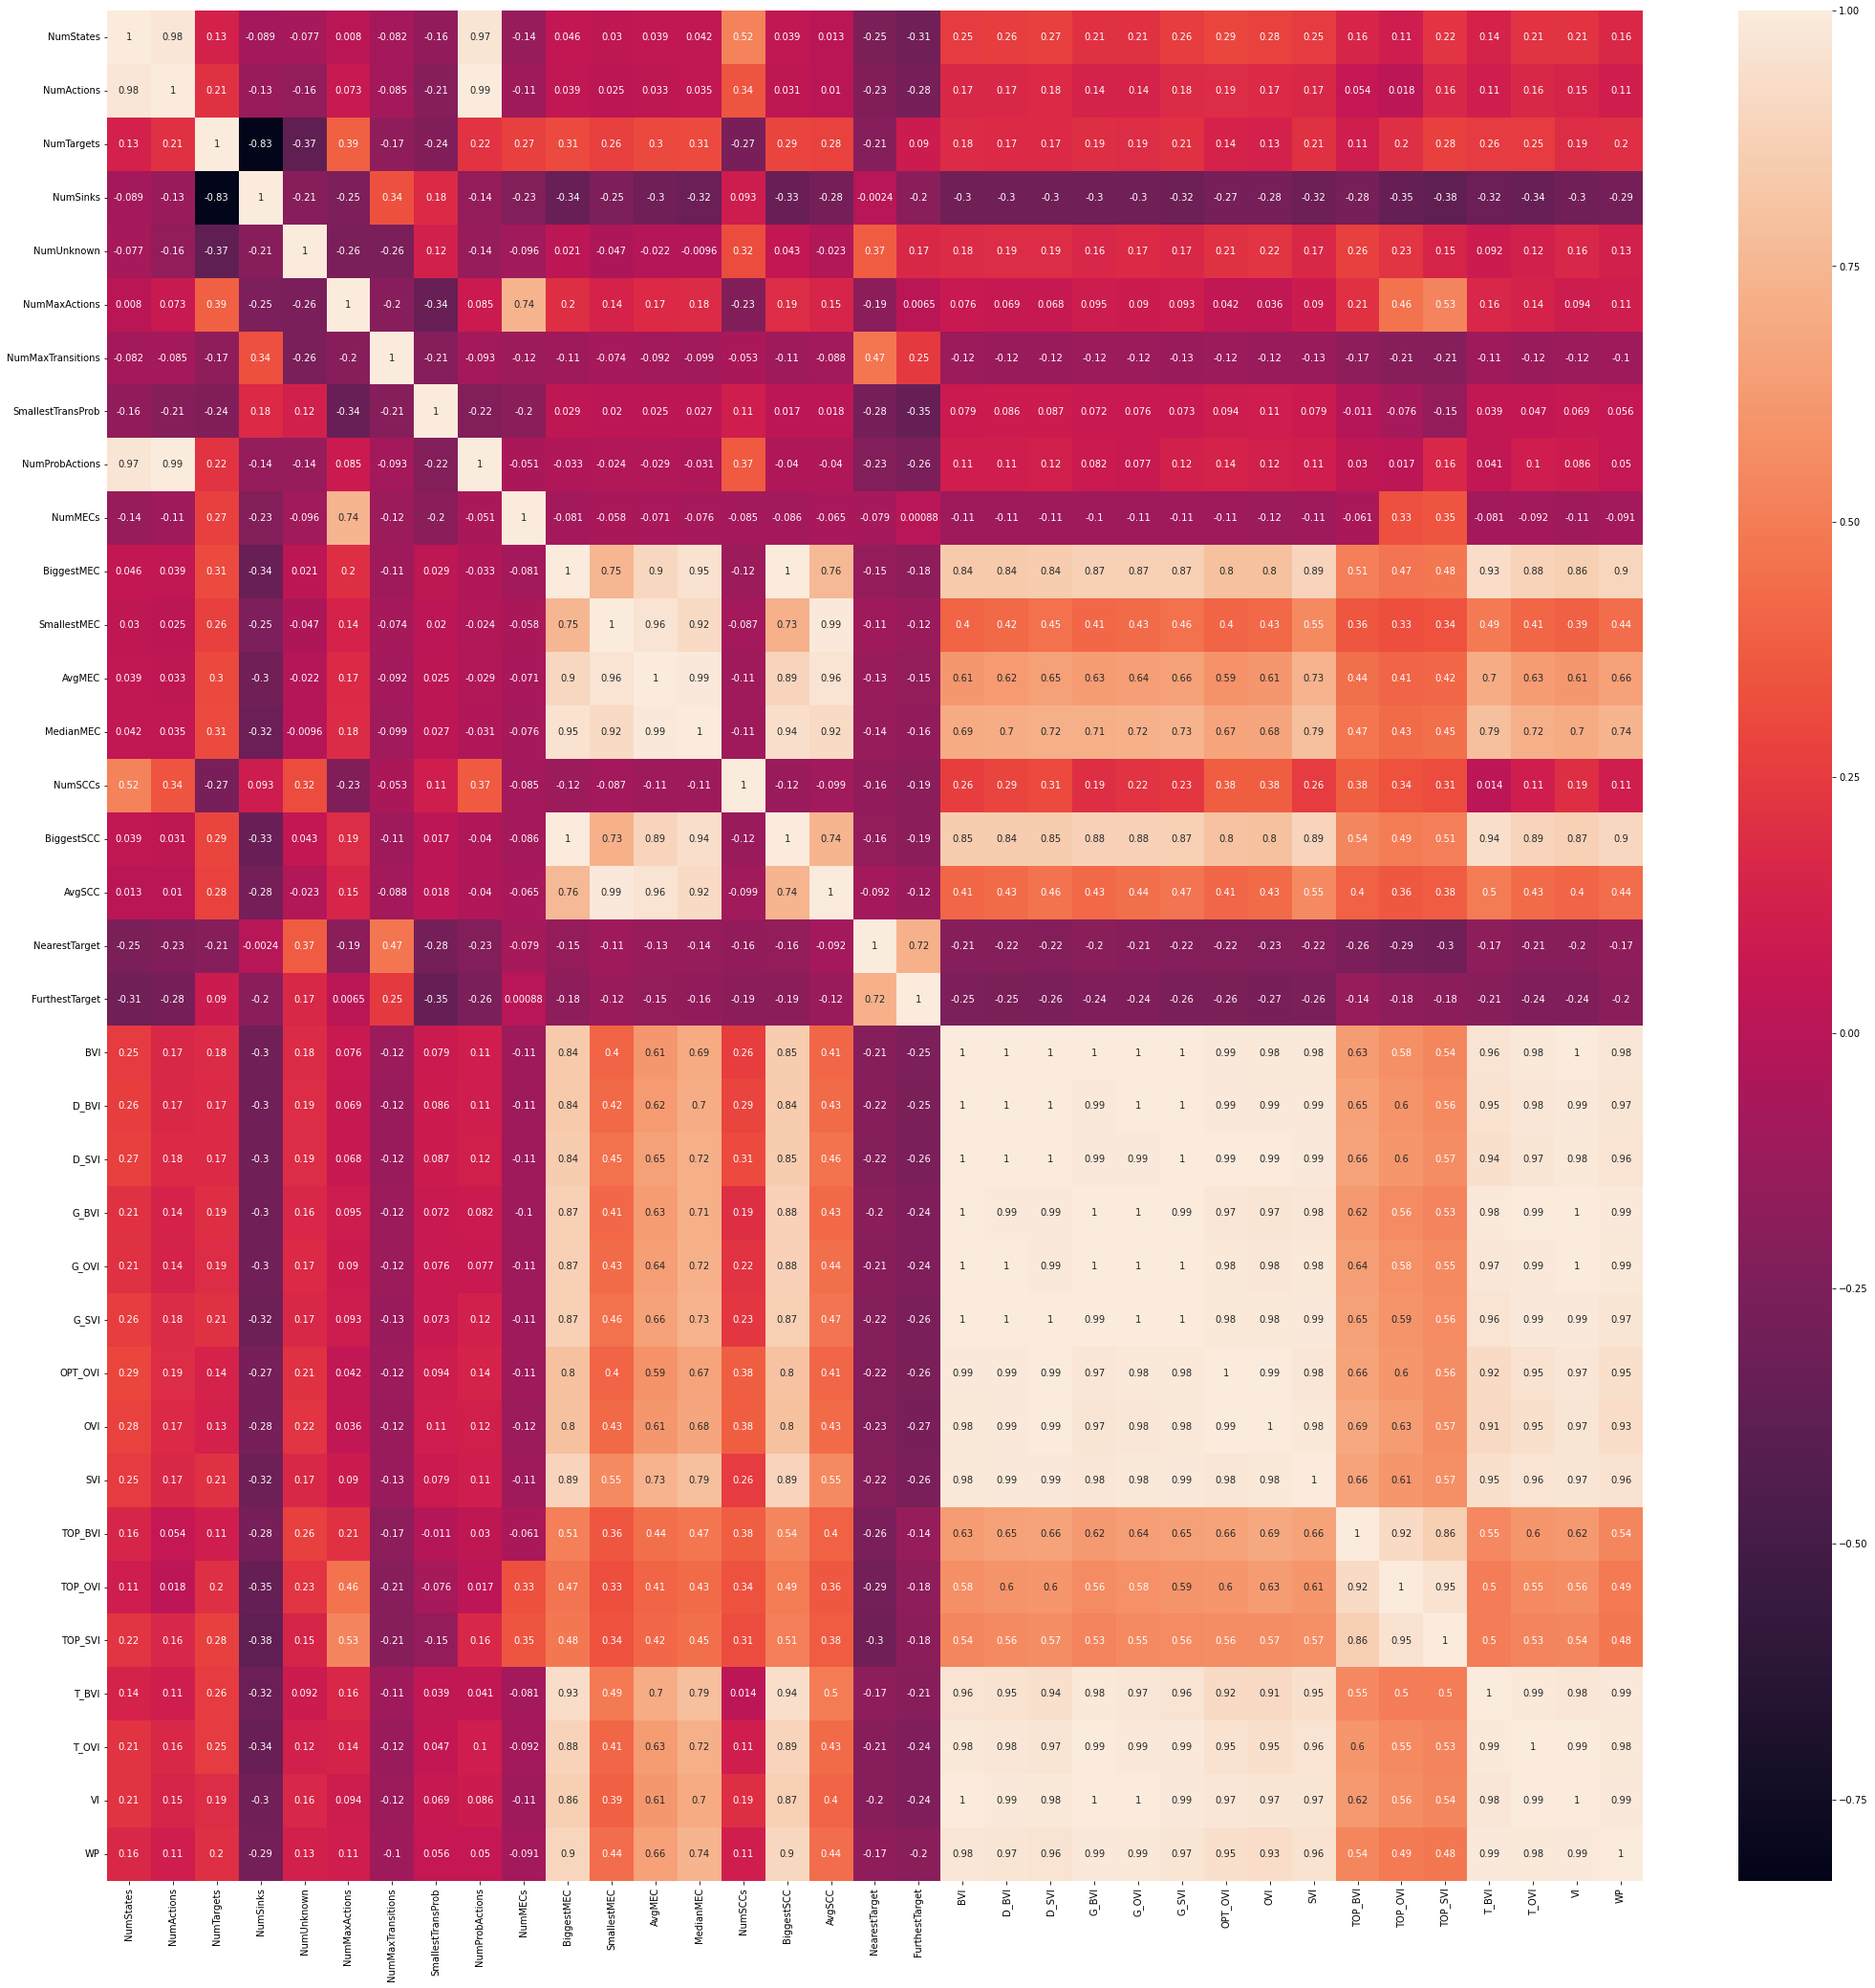

In [1801]:
#Linear Correlation
fig = plt.figure(figsize=(size,size))

df = pd.DataFrame(correlation_dict,columns=correlation_dict.keys())

corrMatrix = df.corr()
sn.heatmap(corrMatrix, annot=True)
plt.show()


## Scatter Plots

In [1802]:
#Scatterplot
def createScatterPlotForOneProperty(property_key):
    entries_per_column = int(math.sqrt(len(config_keys))+1)
    entries_per_row = entries_per_column
    fix, axs = plt.subplots(entries_per_row, entries_per_column, figsize=(16,16), sharey=True)
    row = 0
    column = 0
    for key in config_keys:
        if (column == entries_per_column):
            row += 1
            column = 0
        axs[row, column].scatter(data[property_key], data[key])
        axs[row, column].set_xlabel(property_key),
        axs[row, column].set_ylabel(key)
        column+=1

def createScatterPlotForOneConfig(property_keys):
    entries_per_column = 1    
    entries_per_row = len(property_keys)
    fix, axs = plt.subplots(entries_per_row, entries_per_column, figsize=(12,12), constrained_layout=True)
    row = 0
    column = 0
    for property_key in property_keys:
        for key in config_keys:
            if (column == entries_per_column):
                row += 1
                column = 0
            axs[row].scatter(data[property_key], data[key])
            axs[row].set_xlabel(property_key),
            axs[row].set_ylabel(key)
            column+=1

def createScatterPlotForMultipleProperties(property_keys):
    entries_per_column = len(config_keys)
    entries_per_row = len(property_keys)
    fix, axs = plt.subplots(entries_per_row, entries_per_column, figsize=(12,20), constrained_layout=True)
    row = 0
    column = 0
    for property_key in property_keys:
        for key in config_keys:
            if (column == entries_per_column):
                row += 1
                column = 0
            if (USE_LABELS):
                axs[row, column].scatter(data[property_key], data[key], alpha=0.5, c=pandas_labels.map(coloring))
            else:
                axs[row, column].scatter(data[property_key], data[key], alpha=0.2)
            axs[row, column].set_xlabel(property_key),
            axs[row, column].set_ylabel(key)
            column+=1

def createHistPlotForMultipleProperties(property_keys):
    entries_per_column = len(config_keys)
    entries_per_row = len(property_keys)
    fix, axs = plt.subplots(entries_per_row, entries_per_column, figsize=(12,12), constrained_layout=True)
    row = 0
    column = 0
    for property_key in property_keys:
        for key in config_keys:
            if (column == entries_per_column):
                row += 1
                column = 0
            sn.histplot(x = data[property_key], y =  data[config_key], cbar=True)
            axs[row, column].set_xlabel(property_key),
            axs[row, column].set_ylabel(key)
            column+=1

/home/sascha/.local/lib/python3.9/site-packages/IPython/core/pylabtools.py:137: UserWarning: constrained_layout not applied because axes sizes collapsed to zero.  Try making figure larger or axes decorations smaller.
  fig.canvas.print_figure(bytes_io, **kw)


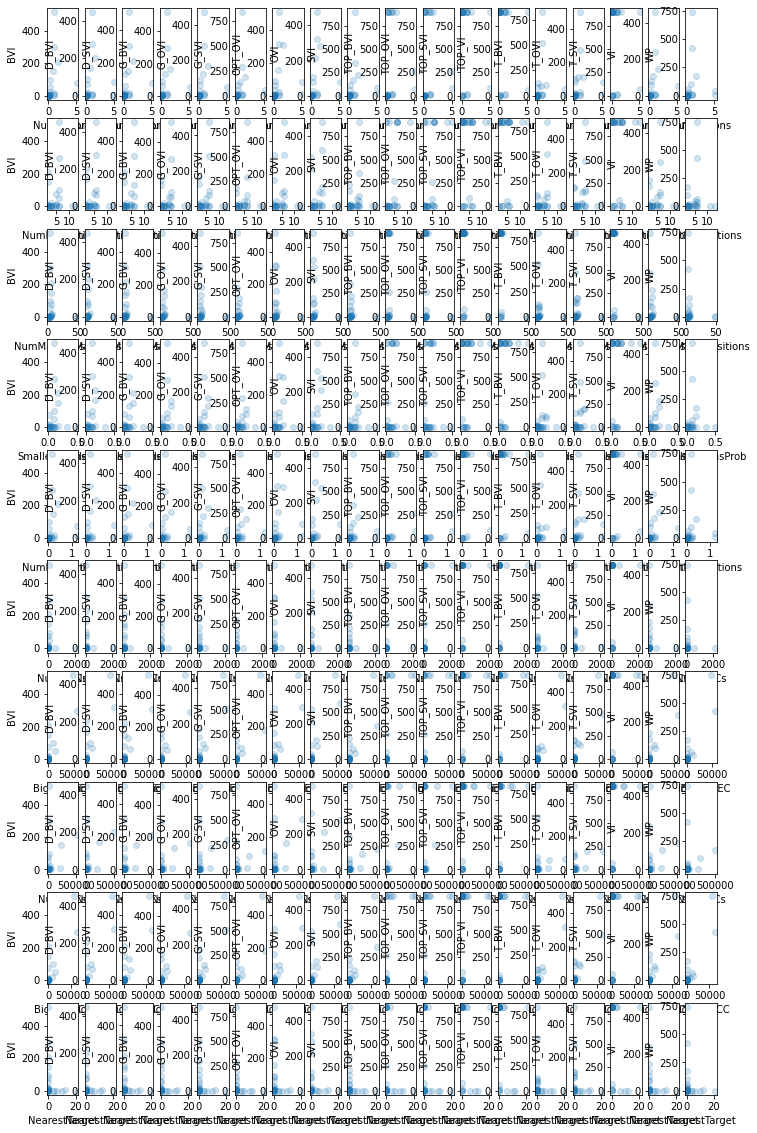

In [1571]:
if(USE_LABELS):
    print(coloring)

createScatterPlotForMultipleProperties(
    [
        #"NumStates",
        #"NumTargets",
        #"NumSinks",
        #"NumUnknown",
        "NumActions",
        "NumMaxActions",
        "NumMaxTransitions",
        "SmallestTransProb",
        "NumProbActions",
        "NumMECs",
        "BiggestMEC",
        #"SmallestMEC",
        #"AvgMEC",
        #"MedianMEC",
        "NumSCCs",
        "BiggestSCC",
        #"AvgSCC",
        "NearestTarget",
        #"FurthestTarget"
    ]
)

In [1329]:
#createHistPlotForMultipleProperties(["BiggestMEC", "NumUnknown", "NumMECs", "NumStates", "NumMaxActions", "NumProbActions"])

## Chi-square Tests: Are two features independent?

In [1210]:
def bin_estimate(length):
    return int(1+math.log2(length))

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3]


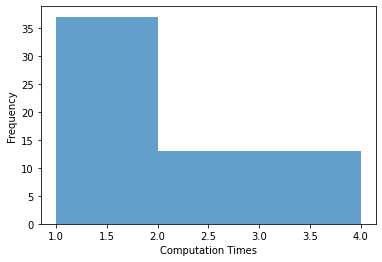

In [1211]:
#Histograms
#Each Bin should contain at least (recommended) 13 entries
#https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.chisquare.html
prop = "NumUnknown"

x_set = [1]*37 + [2]*13 + [3]*13
y_set = [100]*37 + [300]*13 + [500]*13
print(x_set)
x_bins = (1, 2, 3, 4)#bin_estimate(len(data_set))
y_bins = (100, 300, 500, 700)

x_hist_gram = np.histogram(x_set, bins=x_bins)
y_hist_gram = np.histogram(y_set, bins=(100, 200, 300))
n, bins, patches = plt.hist(x=x_set, bins=x_bins, alpha = 0.7)
plt.xlabel('Computation Times')
plt.ylabel('Frequency')

plt.show()


[[37.  0.  0.]
 [ 0. 13.  0.]
 [ 0.  0. 13.]]


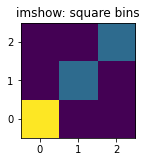

In [1062]:

H, xedges, yedges = np.histogram2d(x_set, y_set, bins=(x_bins, y_bins))
print(H)
# Histogram does not follow Cartesian convention (see Notes),

# therefore transpose H for visualization purposes.

H = H.T
fig = plt.figure(figsize=(7, 7))

ax = fig.add_subplot(131, title='imshow: square bins')

plt.imshow(H, interpolation='nearest', origin='lower')

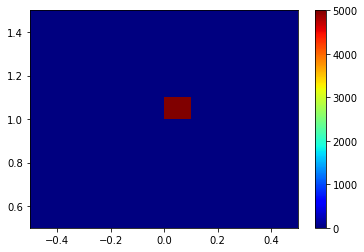

In [1063]:
# create data
x = [0]*5000#np.random.normal(size=5000)
y = [1]*5000#np.random.normal(size=5000)
 
# Big bins
H, x_edges, y_edges, img = plt.hist2d(x, y, bins=(10,10), cmap=plt.cm.jet)
plt.colorbar()
plt.show()

# Small bins
#plt.hist2d(x, y, bins=(300, 300), cmap=plt.cm.jet)
#plt.show()
 
# If you do not set the same values for X and Y, the bins won't be a square!
#plt.hist2d(x, y, bins=(300, 30), cmap=plt.cm.jet)
#plt.show()

In [ ]:
#print(H)
ChiSq, p = stats.chisquare(np.ndarray.flatten(H))
print(ChiSq)
print(p)